# Economic Dispatch

In [1]:
import Pkg
Pkg.activate(@__DIR__)
Pkg.instantiate()

  Activating project at `c:\Users\fenya\Documents\BEE4750\Project\FP-Group6`


In [2]:
Pkg.add("Plots")

   Resolving package versions...
  No Changes to `C:\Users\fenya\Documents\BEE4750\Project\FP-Group6\Project.toml`
  No Changes to `C:\Users\fenya\Documents\BEE4750\Project\FP-Group6\Manifest.toml`


In [3]:
using JuMP
using HiGHS
using DataFrames
using Plots
using Measures
using CSV
using MarkdownTables
# using NamedArrays
using Dates
using LaTeXStrings

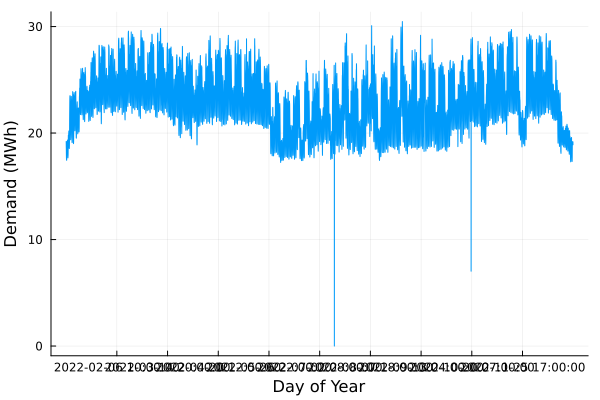

In [4]:
# load the data, pull Zone C, and reformat the DataFrame
CU_edemand = DataFrame(CSV.File("data/Cornell_Electricity_Data.csv"))
rename!(CU_edemand, :"slottime_GMT" => :Date)
edemand = CU_edemand[:, [:Date, :slotavg]]
rename!(edemand, :slotavg => :edemand)
# demand[:, :Hour] = 1:nrow(demand)

# plot demand
plot(edemand.Date, edemand.edemand, xlabel="Day of Year", ylabel="Demand (MWh)", label=:false)

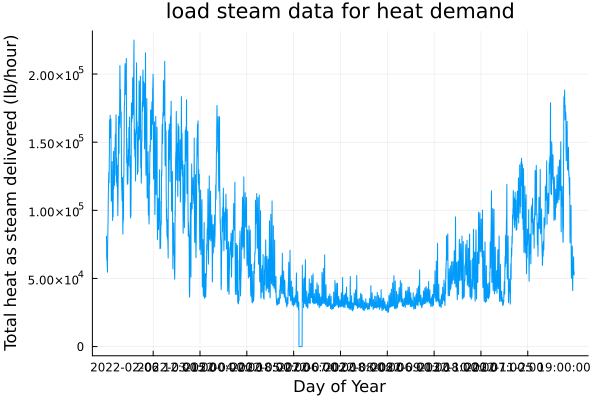

In [5]:
# load steam data for heat demand
CU_hdemand = DataFrame(CSV.File("data/Cornell_steam_data.csv"))
rename!(CU_hdemand, :"slottime_GMT" => :Date)
hdemand = CU_hdemand[:, [:Date, :slotavg]]
rename!(hdemand, :slotavg => :hdemand)

# Converting to units of MMBTU of heat produced (before distribution losses)

# plot demand
plot(hdemand.Date, hdemand.hdemand, title="load steam data for heat demand", xlabel="Day of Year", ylabel="Total heat as steam delivered (lb/hour)", label=:false)

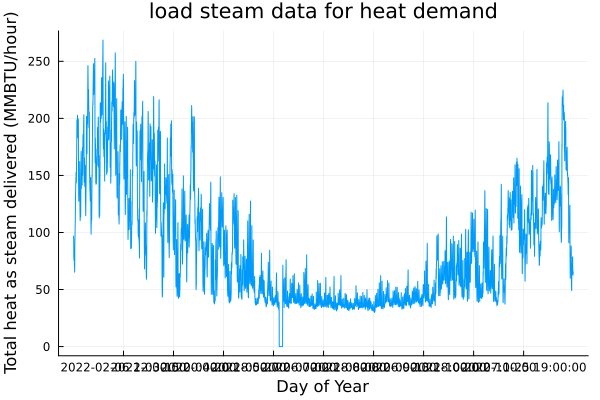

In [6]:
# load steam data for heat demand
CU_hdemand = DataFrame(CSV.File("data/Cornell_steam_data.csv"))
rename!(CU_hdemand, :"slottime_GMT" => :Date)
hdemand = CU_hdemand[:, [:Date, :slotavg]]
rename!(hdemand, :slotavg => :hdemand)

# Converting to units of MMBTU of heat produced (before distribution losses)
hdemand.hdemand = hdemand.hdemand*0.001194
# demand[:, :Hour] = 1:nrow(demand)

# plot demand
plot(hdemand.Date, hdemand.hdemand, title="load steam data for heat demand", xlabel="Day of Year", ylabel="Total heat as steam delivered (MMBTU/hour)", label=:false)

In [7]:
hdemand.hdemand

8752-element Vector{Float64}:
 96.795368115
 95.045805885
 95.13357981
 93.852176025
 88.35585672
 78.72725266500001
 78.75524300999999
 77.462203695
 75.645467025
 79.375815555
  ⋮
 68.72027001
 66.368433285
 66.65727681
 65.19214926
 62.68227768
 63.703807364999996
 63.56257805999999
 64.77608802
 65.333444235

In [8]:
# Information about different generation and heating sources
# gens is electricity - natural gas is CHP 
# -- heat pumps run on electricity and produce heat
gens = DataFrame(CSV.File("data/Gen_data_CU.csv"))

# heat is heat
heat = DataFrame(CSV.File("data/Heat_data_CU.csv"))

3×5 DataFrame
 Row │ Column1  Capacity  VarCost       Emissions       Conversion_Factor 
     │ String3  Int64?    Float64?      Float64?        Float64           
─────┼────────────────────────────────────────────────────────────────────
   1 │ NG             30       27.5345        0.575831          0.0837521
   2 │ HPs           100        0.0           0.0               0.0814086
   3 │ ESH       missing  missing       missing                 0.025708

Finally, we load the hourly solar and wind capacity factors, which are
plotted in <a href="#fig-cf" class="quarto-xref">Figure 2</a>. These
tell us the fraction of installed capacity which is expected to be
available in a given hour for generation (typically based on the average
meteorology).

In [9]:
[Dates.DateTime(edemand.Date[i], dateformat"yyyy-mm-dd HH:MM:SS") for i in 1:length(edemand.Date)]

8736-element Vector{DateTime}:
 2022-01-01T00:00:00
 2022-01-01T01:00:00
 2022-01-01T02:00:00
 2022-01-01T03:00:00
 2022-01-01T04:00:00
 2022-01-01T05:00:00
 2022-01-01T06:00:00
 2022-01-01T07:00:00
 2022-01-01T08:00:00
 2022-01-01T09:00:00
 ⋮
 2022-12-31T15:00:00
 2022-12-31T16:00:00
 2022-12-31T17:00:00
 2022-12-31T18:00:00
 2022-12-31T19:00:00
 2022-12-31T20:00:00
 2022-12-31T21:00:00
 2022-12-31T22:00:00
 2022-12-31T23:00:00

In [10]:
transform(edemand, :Date => (ByRow(t -> Dates.DateTime(t, dateformat"yyyy-mm-dd HH:MM:SS"))) => :Date)

8736×2 DataFrame
  Row │ Date                 edemand 
      │ DateTime             Float64 
──────┼──────────────────────────────
    1 │ 2022-01-01T00:00:00  19.2144
    2 │ 2022-01-01T01:00:00  18.705
    3 │ 2022-01-01T02:00:00  18.5034
    4 │ 2022-01-01T03:00:00  18.0225
    5 │ 2022-01-01T04:00:00  17.6864
    6 │ 2022-01-01T05:00:00  17.6017
    7 │ 2022-01-01T06:00:00  17.4555
    8 │ 2022-01-01T07:00:00  17.6025
  ⋮   │          ⋮              ⋮
 8730 │ 2022-12-31T17:00:00  19.2005
 8731 │ 2022-12-31T18:00:00  19.1328
 8732 │ 2022-12-31T19:00:00  18.9942
 8733 │ 2022-12-31T20:00:00  18.8982
 8734 │ 2022-12-31T21:00:00  19.0662
 8735 │ 2022-12-31T22:00:00  19.1818
 8736 │ 2022-12-31T23:00:00  18.9005
                    8721 rows omitted

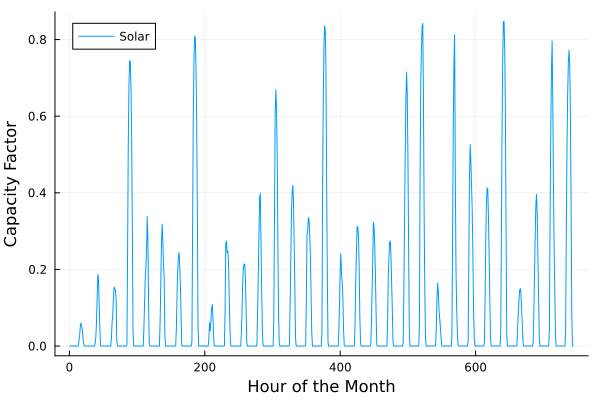

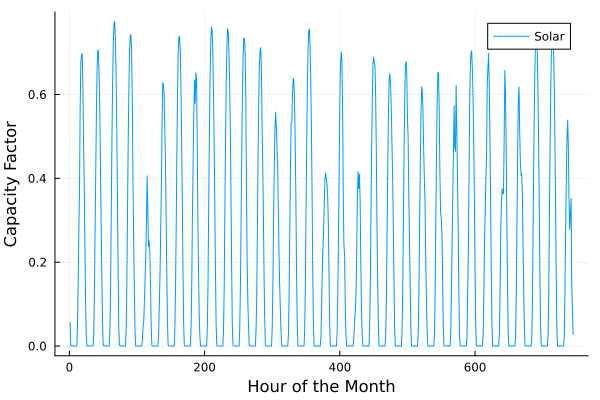

In [11]:
cap_factor = DataFrame(CSV.File("data/2022_solar_CF_zone_C.csv", header=4))
cap_factor=  cap_factor[:, [:time, :electricity]]
rename!(cap_factor, :electricity => :Solar)

# plot January capacity factors
# p1 = plot(cap_factor.Wind[1:(24*31)], label="Wind")
p1 = plot(cap_factor.Solar[1:(24*31)], label="Solar")
xaxis!("Hour of the Month")
yaxis!("Capacity Factor")

# p2 = plot(cap_factor.Wind[4344:4344+(24*31)], label="Wind")
p2 = plot(cap_factor.Solar[4344:4344+(24*31)], label="Solar")
xaxis!("Hour of the Month")
yaxis!("Capacity Factor")

display(p1)
display(p2)

## Drop missing data

In [12]:
e_missing_dates = setdiff(DateTime(2022, 1, 1, 0):Hour(1):DateTime(2022, 12, 31, 23),[Dates.DateTime(edemand.Date[i], dateformat"yyyy-mm-dd HH:MM:SS") for i in 1:length(edemand.Date)])
h_missing_dates = setdiff(DateTime(2022, 1, 1, 0):Hour(1):DateTime(2022, 12, 31, 23),[Dates.DateTime(hdemand.Date[i], dateformat"yyyy-mm-dd HH:MM:SS") for i in 1:length(hdemand.Date)])
cap_factor = DataFrame(CSV.File("data/2022_solar_CF_zone_C.csv", header=4))
cap_factor=  cap_factor[:, [:time, :electricity]]
rename!(cap_factor, :electricity => :Solar)
missing_dates = [h_missing_dates; e_missing_dates]
e_dts = [Dates.DateTime(edemand.Date[i], dateformat"yyyy-mm-dd HH:MM:SS") for i in 1:length(edemand.Date)]
h_dts = [Dates.DateTime(hdemand.Date[i], dateformat"yyyy-mm-dd HH:MM:SS") for i in 1:length(hdemand.Date)]
cf_dts = [Dates.DateTime(cap_factor.time[i], dateformat"mm/dd/yyyy HH:MM") for i in 1:length(cap_factor.time)]
cap_factor = cap_factor[[cf_dts[i] ∉ missing_dates for i in 1:length(cap_factor.time)],:]
edemand = edemand[[e_dts[i] ∉ missing_dates for i in 1:length(edemand.Date)],:]
hdemand = hdemand[[h_dts[i] ∉ missing_dates for i in 1:length(hdemand.Date)],:]

8736×2 DataFrame
  Row │ Date                 hdemand 
      │ String31             Float64 
──────┼──────────────────────────────
    1 │ 2022-01-01 00:00:00  96.7954
    2 │ 2022-01-01 01:00:00  95.0458
    3 │ 2022-01-01 02:00:00  95.1336
    4 │ 2022-01-01 03:00:00  93.8522
    5 │ 2022-01-01 04:00:00  88.3559
    6 │ 2022-01-01 05:00:00  78.7273
    7 │ 2022-01-01 06:00:00  78.7552
    8 │ 2022-01-01 07:00:00  77.4622
  ⋮   │          ⋮              ⋮
 8730 │ 2022-12-31 17:00:00  66.6573
 8731 │ 2022-12-31 18:00:00  65.1921
 8732 │ 2022-12-31 19:00:00  62.6823
 8733 │ 2022-12-31 20:00:00  63.7038
 8734 │ 2022-12-31 21:00:00  63.5626
 8735 │ 2022-12-31 22:00:00  64.7761
 8736 │ 2022-12-31 23:00:00  65.3334
                    8721 rows omitted

## Solutions

Scenario 1 (no heating constraint)

Decision variables:
$x_{g}$ = Installed capacity for generator type g (MW)

$y_{g,t}$ = Production from generator g in time t (MWh)

$NSE_{t}$ = non-served energy in time t (MWh)

Minimize total cost = fixed cost + variable cost + unserved energy cost
\begin{align}
\min_{x, y, NSE} \quad & \sum_{g \in \mathcal{G}} \text{FixedCost}_g \times x_g + \sum_{t \in \mathcal{T}} \sum_{g \in \mathcal{G}} \text{VarCost}_g \times y_{g,t} & \\
& \quad + \sum_{t \in \mathcal{T}} \text{NSECost} \times NSE_t & \\[0.5em]
\text {subject to:} \quad & \sum_{g \in \mathcal{G}} y_{g,t} + NSE_t \geq d_t \qquad \forall t \in \mathcal{T} \\[0.5em]
\text{(Meeting demand in each hour)} \\
& y_{g,t} \leq x_g*c_{g,t} \qquad \qquad \qquad\qquad  \forall g \in {G},  \forall t \in \mathcal{T} \\[0.5em]
\text{(Generator capacity limits)} \\
& x_g, y_{g,t}, NSE_t \geq 0 \qquad \qquad \forall g \in {G},  \forall t \in \mathcal{T}
\end{align}

Economic Dispatch with CHP

Decision variables:

$y_{g,t}$ = Production from generator g in time t (MWh)

$z_{s,t}$ = Heat production from source s in time t (MWh)

$NSE_{t}$ = non-served energy in time t (MWh)

Parameters:

r = Conversion factor for CHP, MWh produced per MMBTU produced

$c_{hp,t}$ = Conversion factor for heat pump, MWh required per MMBTU produced


Minimize total cost = fixed cost + variable cost + unserved energy cost
\begin{align}
\sum_{t \in \mathcal{T}} \sum_{g \in \mathcal{G}} \text{VarCost}_g \times y_{g,t} \quad + \sum_{t \in \mathcal{T}} \text{NSECost} \times NSE_t & \\[0.5em]
\text {subject to:} \quad & \sum_{g \in \mathcal{G}} y_{g,t} + NSE_t \geq d_t + c_{hp,t}* z_{hp,t} \qquad \forall t \in \mathcal{T} \\[0.5em]
\text{(Meeting demand in each hour)} \\
\quad & \sum_{s \in \mathcal{S}} h_{s,t} \geq zd_t \qquad \forall t \in \mathcal{T} \\[0.5em]
\text{(Meeting heating demand in each hour)} \\
\quad & z_{n,t} = r*y_{n,t} \qquad \forall t \in \mathcal{T} \\[0.5em]
\text{(Assume constant ratio of heat to electricty production from natural gas)} \\
& y_{g,t} \leq x_g*c_{g,t} \qquad \qquad \qquad\qquad  \forall g \in {G},  \forall t \in \mathcal{T} \\[0.5em]
\text{(Generator capacity limits)} \\
& x_g, y_{g,t}, NSE_t \geq 0 \qquad \qquad \forall g \in {G},  \forall t \in \mathcal{T}
\end{align}

In [13]:
# capacity factor for gas will be 1 --> this sets the capacity factor as 1 for every day of the year
cap_factor[:, :Gas] .=1

# cap_factor[:, :Geothermal] .=0.8
# cap_factor[:, :NG_CCGT] .=1
# cap_factor[:, :NG_CT] .=1

# all capacity factors together into one data frame
select!(cap_factor, :Gas, :Solar)

8736×2 DataFrame
  Row │ Gas    Solar   
      │ Int64  Float64 
──────┼────────────────
    1 │     1    0.0
    2 │     1    0.0
    3 │     1    0.0
    4 │     1    0.0
    5 │     1    0.0
    6 │     1    0.0
    7 │     1    0.0
    8 │     1    0.0
  ⋮   │   ⋮       ⋮
 8730 │     1    0.168
 8731 │     1    0.06
 8732 │     1    0.027
 8733 │     1    0.011
 8734 │     1    0.0
 8735 │     1    0.0
 8736 │     1    0.0
      8721 rows omitted

In [14]:
# No heat, Just electricity no heatpumps
# define sets
G = 1:nrow(gens)
T = 1:nrow(edemand)
NSECost = 10000

gencap = Model(HiGHS.Optimizer)
# define variables
@variables(gencap, begin
    y[g in G, t in T] >= 0
    NSE[t in T] >= 0
end)

(2-dimensional DenseAxisArray{VariableRef,2,...} with index sets:
    Dimension 1, 1:2
    Dimension 2, 1:8736
And data, a 2×8736 Matrix{VariableRef}:
 y[1,1]  y[1,2]  y[1,3]  y[1,4]  y[1,5]  …  y[1,8734]  y[1,8735]  y[1,8736]
 y[2,1]  y[2,2]  y[2,3]  y[2,4]  y[2,5]     y[2,8734]  y[2,8735]  y[2,8736], 1-dimensional DenseAxisArray{VariableRef,1,...} with index sets:
    Dimension 1, 1:8736
And data, a 8736-element Vector{VariableRef}:
 NSE[1]
 NSE[2]
 NSE[3]
 NSE[4]
 NSE[5]
 NSE[6]
 NSE[7]
 NSE[8]
 NSE[9]
 NSE[10]
 ⋮
 NSE[8728]
 NSE[8729]
 NSE[8730]
 NSE[8731]
 NSE[8732]
 NSE[8733]
 NSE[8734]
 NSE[8735]
 NSE[8736])

In [15]:
# Optimizing cost (cost is constant over time per mwh) of just electricity

# define sets
G = 1:nrow(gens)
T = 1:nrow(edemand)
NSECost = 10000

gencap = Model(HiGHS.Optimizer)
# define variables
@variables(gencap, begin
    y[g in G, t in T] >= 0
    NSE[t in T] >= 0
end)

@objective(gencap, Min, 
   sum(gens[G, :VarCost] .* sum(y[:, t] for t in T)) + NSECost * sum(NSE)
)

@constraint(gencap, load[t in T], sum(y[:, t]) + NSE[t] >= edemand.edemand[t])

@constraint(gencap, availability[g in G, t in T], y[g, t] <= gens[g, :Capacity]*cap_factor[t,g])
optimize!(gencap)



Running HiGHS 1.8.1 (git hash: 4a7f24ac6): Copyright (c) 2024 HiGHS under MIT licence terms
Coefficient ranges:
  Matrix [1e+00, 1e+00]
  Cost   [3e+01, 1e+04]
  Bound  [0e+00, 0e+00]
  RHS    [1e-01, 1e+02]
Presolving model
8735 rows, 17470 cols, 17470 nonzeros  0s
5993 rows, 11986 cols, 11986 nonzeros  0s
Presolve : Reductions: rows 5993(-20215); columns 11986(-14222); elements 11986(-31694)
Solving the presolved LP
Using EKK dual simplex solver - serial
  Iteration        Objective     Infeasibilities num(sum)
          0     0.0000000000e+00 Pr: 5993(117375) 0s
       5993     3.2318777195e+06 Pr: 0(0) 0s
Solving the original LP from the solution after postsolve
Model status        : Optimal
Simplex   iterations: 5993
Objective value     :  3.2318777195e+06
Relative P-D gap    :  5.7633527964e-16
HiGHS run time      :          0.19


In [16]:
NoHeat_cost = @show objective_value(gencap)

objective_value(gencap) = 3.2318777194890766e6


3.2318777194890766e6

Objective value wihtout heat is $4476878

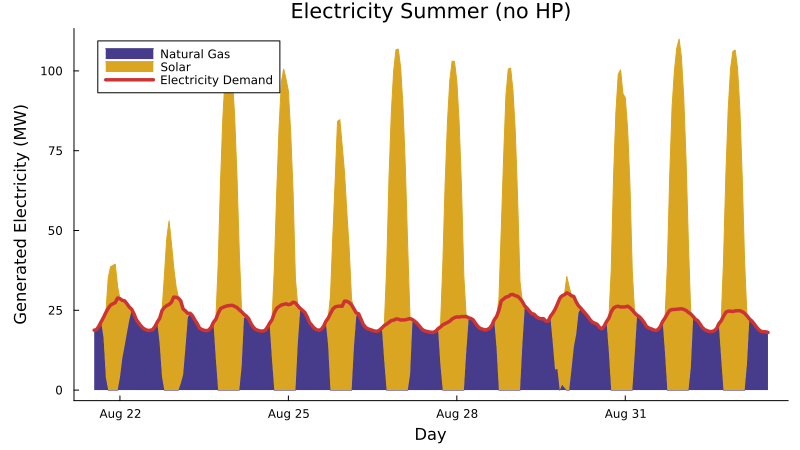

In [17]:
# Plotting natural gas and solar generation at the optimized cost
# This is just optimizing to meet electricity demand
x_labels = ["Aug 22", "Aug 25", "Aug 28", "Aug 31", "Sept 3"]

gen = value.(y).data 
p = areaplot(gen'[5593:5881,:], 
    label=["Natural Gas" "Solar"], 
    xlabel = "Day", 
    ylabel ="Generated Electricity (MW)", 
    color_palette=[:slateblue4, :goldenrod],
    grid=:false,
    # ylim=(0, 100),
)

plot!(p, edemand.edemand[5593:5881, :], label="Electricity Demand", color=:brown3, linewidth=3.5)
plot!(xticks=(12:72:288, x_labels))

plot!(legend=:topleft, title = "Electricity Summer (no HP)", legendcolumns=1, leftmargin=5mm, bottommargin=3mm)
plot!(p, size=(800, 450))

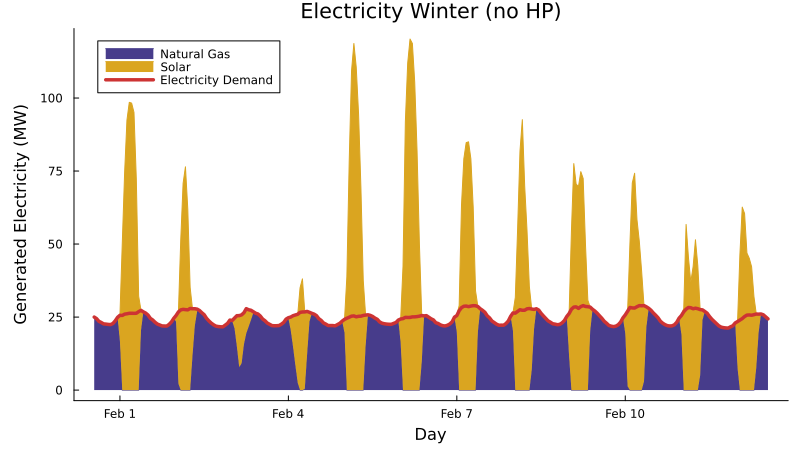

In [18]:
x_labels = ["Feb 1", "Feb 4", "Feb 7", "Feb 10", "Feb 12"]
gen = value.(y).data 
p = areaplot(gen'[745:1033,:], 
    label=["Natural Gas" "Solar"], 
    xlabel = "Day", 
    ylabel ="Generated Electricity (MW)", 
    color_palette=[:slateblue4, :goldenrod],
    grid=:false,
    # ylim=(0, 100),
)

plot!(p, edemand.edemand[745:1033, :], label="Electricity Demand", color=:brown3, linewidth=3.5)
# Customize the x-axis labels
plot!(xticks=(12:72:288, x_labels))

plot!(legend=:topleft, title = "Electricity Winter (no HP)", legendcolumns=1, leftmargin=5mm, bottommargin=3mm)
plot!(p, size=(800, 450))

## No heat pumps, electricity as only constrain, optimizing for emissions

In [19]:
# Optimizing emissions just electricity

# define sets
G = 1:nrow(gens)
T = 1:nrow(edemand)
NSECost = 10000

gencap = Model(HiGHS.Optimizer)
# define variables
@variables(gencap, begin
    y[g in G, t in T] >= 0
end)

@objective(gencap, Min, 
   sum(gens[G, :Emissions] .* sum(y[:, t] for t in T))
)

@constraint(gencap, load[t in T], sum(y[:, t]) >= edemand.edemand[t])

@constraint(gencap, availability[g in G, t in T], y[g, t] <= gens[g, :Capacity]*cap_factor[t,g])
optimize!(gencap)



Running HiGHS 1.8.1 (git hash: 4a7f24ac6): Copyright (c) 2024 HiGHS under MIT licence terms
Coefficient ranges:
  Matrix [1e+00, 1e+00]
  Cost   [6e-01, 6e-01]
  Bound  [0e+00, 0e+00]
  RHS    [1e-01, 1e+02]
Presolving model
4380 rows, 4380 cols, 4380 nonzeros  0s
0 rows, 0 cols, 0 nonzeros  0s
Presolve : Reductions: rows 0(-26208); columns 0(-17472); elements 0(-34944) - Reduced to empty
Solving the original LP from the solution after postsolve
Model status        : Optimal
Objective value     :  6.7588399307e+04
Relative P-D gap    :  1.7224157255e-15
HiGHS run time      :          0.03


In [20]:
NoHeat_emissions = @show objective_value(gencap)

objective_value(gencap) = 67588.39930655723


67588.39930655723

Objective value wihtout heat is $4476878

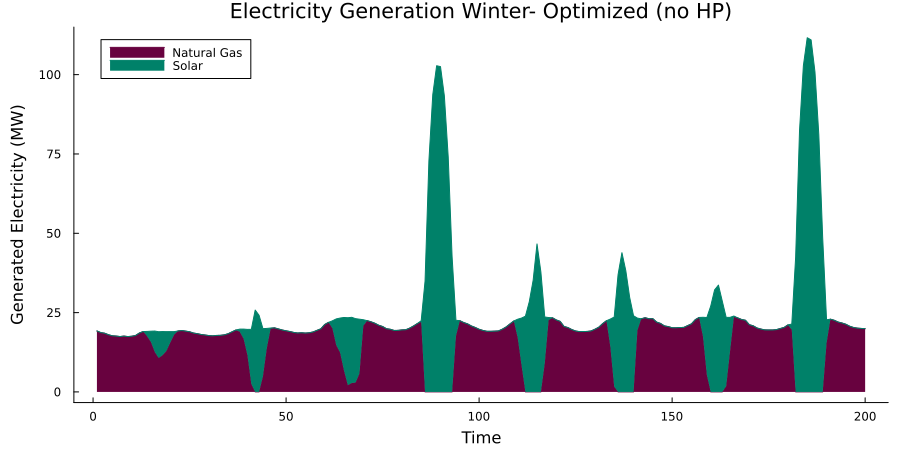

In [21]:
# Plotting natural gas and solar generation at the optimized cost
# This is just optimizing to meet electricity demand

gen = value.(y).data 
p = areaplot(gen'[1:200,:], 
    label=["Natural Gas" "Solar"], 
    xlabel = "Time", 
    ylabel ="Generated Electricity (MW)", 
    color_palette=:mk_15,
    grid=:false,
    # ylim=(0, 100),
)
plot!(legend=:topleft, title = "Electricity Generation Winter- Optimized (no HP)", legendcolumns=1, leftmargin=5mm, bottommargin=3mm)
plot!(p, size=(900, 450))

In [22]:
# THis is the plot of electricity generation with heat pumps so demand is higher
# remake for more hours
x_labels = ["Aug 22", "Aug 25", "Aug 28", "Aug 31", "Sept 3"]

gen = value.(y).data 
p = areaplot(gen'[5593:5881,:], 
    label=["Natural Gas" "Solar"], 
    xlabel = "Time", 
    ylabel ="Generated Electricity (MW)", 
    color_palette=[:slateblue4, :goldenrod],
    grid=:false,
    # ylim=(0, 100),
)

plot!(p, edemand.edemand[5593:5881, :], label="Electricity Demand", color=:brown3, linewidth=3.5)
plot!(xticks=(12:72:288, x_labels)) 

plot!(legend=:topleft, legendcolumns=1, title="Electricity with no GSHPs or ESH - Summer \n (Only Electricity Demand Constrained)", topmargin=5mm, leftmargin=5mm, bottommargin=5mm)
plot!(p, size=(800, 450))
savefig("Elec1_Summer.png")

"c:\\Users\\fenya\\Documents\\BEE4750\\Project\\FP-Group6\\Elec1_Summer.png"

In [23]:
x_labels = ["Feb 1", "Feb 4", "Feb 7", "Feb 10", "Feb 12"]
# THis is the plot of electricity generation with heat pumps so demand is higher
# remake for more hours
gen = value.(y).data 
p = areaplot(gen'[745:1033,:], 
    label=["Natural Gas" "Solar"], 
    xlabel = "Time", 
    ylabel ="Generated Electricity (MW)", 
    color_palette=[:slateblue4, :goldenrod],
    grid=:false,
    # ylim=(0, 100),
)

plot!(p, edemand.edemand[745:1033, :], label="Electricity Demand", color=:brown3, linewidth=3.5)
# Customize the x-axis labels
plot!(xticks=(12:72:288, x_labels))

plot!(legend=:topleft, legendcolumns=1, title="Electricity with no GSHPs or ESH - Winter \n (Only Electricity Demand Constrained)", topmargin=5mm, leftmargin=5mm, bottommargin=5mm)
plot!(p, size=(800, 450))
savefig("Elec1_Winter.png")

"c:\\Users\\fenya\\Documents\\BEE4750\\Project\\FP-Group6\\Elec1_Winter.png"

## Natural Gas, No Heat Pumps

#### Electricity and heat demand as is (with no heat pumps)

In [24]:
# Optimizing cost of production for electricity and heat - no heat pumps
# define sets
G = 1:nrow(gens)
H = 1:1
T = 1:nrow(edemand)
NSECost = 10000
NSHCost = 5000

gencap = Model(HiGHS.Optimizer)
# define variables
@variables(gencap, begin
    y[g in G, t in T] >= 0
    z[h in H, t in T] >= 0
    NSE[t in T] >= 0
    NSH[t in T] >= 0
end)

@objective(gencap, Min, 
   sum(gens[G, :VarCost] .* sum(y[:, t] for t in T)) + NSECost * sum(NSE) + NSHCost * sum(NSH)
)

# @constraint(gencap, load[t in T], sum(y[:, t]) + NSE[t] >= edemand.edemand[t])
@constraint(gencap, load[t in T], sum(y[:, t]) + NSE[t] >= edemand.edemand[t])
@constraint(gencap, heating[t in T], sum(z[:, t]) + NSH[t] >= hdemand.hdemand[t])
# @constraint(gencap, chp[t in T], y[1, t] >= heat[1, :Conversion_Factor]*z[1, t] )
# @constraint(gencap, chpL[t in T], y[1, t] == 0.083752094*z[1, t] )
@constraint(gencap, chp[t in T], y[1, t] == heat[1, :Conversion_Factor]*z[1, t] )

@constraint(gencap, availability[g in G, t in T], y[g, t] <= gens[g, :Capacity]*cap_factor[t,g])
optimize!(gencap)

Running HiGHS 1.8.1 (git hash: 4a7f24ac6): Copyright (c) 2024 HiGHS under MIT licence terms
Coefficient ranges:
  Matrix [8e-02, 1e+00]
  Cost   [3e+01, 1e+04]
  Bound  [0e+00, 0e+00]
  RHS    [3e-05, 3e+02]
Presolving model
17419 rows, 26155 cols, 34838 nonzeros  0s
14677 rows, 23392 cols, 29354 nonzeros  0s
Presolve : Reductions: rows 14677(-29003); columns 23392(-20288); elements 29354(-49270)
Solving the presolved LP
Using EKK dual simplex solver - serial
  Iteration        Objective     Infeasibilities num(sum)
          0     0.0000000000e+00 Pr: 14677(811297) 0s
       8819     3.7536476297e+06 Pr: 0(0) 0s
Solving the original LP from the solution after postsolve
Model status        : Optimal
Simplex   iterations: 8819
Objective value     :  3.7536476297e+06
Relative P-D gap    :  4.5900599444e-15
HiGHS run time      :          0.29


In [25]:
NoHP_cost = @show objective_value(gencap)

objective_value(gencap) = 3.7536476296884534e6


3.7536476296884534e6

In [26]:
# Cost per unit of MWh 
heating_price = @show shadow_price.(heating)

shadow_price.(heating) = 1-dimensional DenseAxisArray{Float64,1,...} with index sets:
    Dimension 1, 1:8736
And data, a 8736-element Vector{Float64}:
 -0.0
 -0.0
 -0.0
 -0.0
 -0.0
 -0.0
 -0.0
 -0.0
 -0.0
 -0.0
 -0.0
 -0.0
 -0.0
 -0.0
 -0.0
 -0.0
 -0.0
 -0.0
 -0.0
 -0.0
 -0.0
 -0.0
 -0.0
 -0.0
 -0.0
 -0.0
 -0.0
 -0.0
 -0.0
 -0.0
 -0.0
 -0.0
 -0.0
 -0.0
 -0.0
 -0.0
 -0.0
 -0.0
 -0.0
 -2.3060748195126886
 -2.3060748195126886
 -2.3060748195126886
 -2.3060748195126886
 -2.3060748195126886
 -0.0
 -0.0
 -0.0
 -0.0
 -0.0
 -0.0
 -0.0
 -0.0
 -0.0
 -0.0
 -0.0
 -0.0
 -0.0
 -0.0
 -0.0
 -0.0
 -0.0
 -0.0
 -2.3060748195126886
 -2.3060748195126886
 -2.3060748195126886
 -2.3060748195126886
 -2.3060748195126886
 -2.3060748195126886
 -2.3060748195126886
 -0.0
 -0.0
 -0.0
 -0.0
 -0.0
 -0.0
 -0.0
 -0.0
 -0.0
 -0.0
 -0.0
 -0.0
 -0.0
 -0.0
 -0.0
 -0.0
 -2.3060748195126886
 -2.3060748195126886
 -2.3060748195126886
 -2.3060748195126886
 -2.3060748195126886
 -2.3060748195126886
 -2.3060748195126886
 -2.3060748

1-dimensional DenseAxisArray{Float64,1,...} with index sets:
    Dimension 1, 1:8736
And data, a 8736-element Vector{Float64}:
 -0.0
 -0.0
 -0.0
 -0.0
 -0.0
 -0.0
 -0.0
 -0.0
 -0.0
 -0.0
  ⋮
 -2.3060748195126886
 -2.3060748195126886
 -2.3060748195126886
 -0.0
 -0.0
 -0.0
 -0.0
 -0.0
 -0.0

In [27]:
# Cost per unit of MWh 
chp_price = @show shadow_price.(chp)

shadow_price.(chp) = 1-dimensional DenseAxisArray{Float64,1,...} with index sets:
    Dimension 1, 1:8736
And data, a 8736-element Vector{Float64}:
  -0.0
  -0.0
  -0.0
  -0.0
  -0.0
  -0.0
  -0.0
  -0.0
  -0.0
  -0.0
  -0.0
  -0.0
  -0.0
  -0.0
  -0.0
  -0.0
  -0.0
  -0.0
  -0.0
  -0.0
  -0.0
  -0.0
  -0.0
  -0.0
  -0.0
  -0.0
  -0.0
  -0.0
  -0.0
  -0.0
  -0.0
  -0.0
  -0.0
  -0.0
  -0.0
  -0.0
  -0.0
  -0.0
  -0.0
 -27.53453328
 -27.53453328
 -27.53453328
 -27.53453328
 -27.53453328
  -0.0
  -0.0
  -0.0
  -0.0
  -0.0
  -0.0
  -0.0
  -0.0
  -0.0
  -0.0
  -0.0
  -0.0
  -0.0
  -0.0
  -0.0
  -0.0
  -0.0
  -0.0
 -27.53453328
 -27.53453328
 -27.53453328
 -27.53453328
 -27.53453328
 -27.53453328
 -27.53453328
  -0.0
  -0.0
  -0.0
  -0.0
  -0.0
  -0.0
  -0.0
  -0.0
  -0.0
  -0.0
  -0.0
  -0.0
  -0.0
  -0.0
  -0.0
  -0.0
 -27.53453328
 -27.53453328
 -27.53453328
 -27.53453328
 -27.53453328
 -27.53453328
 -27.53453328
 -27.53453328
  -0.0
  -0.0
  -0.0
  -0.0
  -0.0
  -0.0
  -0.0
  -0.0
  -0.

1-dimensional DenseAxisArray{Float64,1,...} with index sets:
    Dimension 1, 1:8736
And data, a 8736-element Vector{Float64}:
  -0.0
  -0.0
  -0.0
  -0.0
  -0.0
  -0.0
  -0.0
  -0.0
  -0.0
  -0.0
   ⋮
 -27.53453328
 -27.53453328
 -27.53453328
  -0.0
  -0.0
  -0.0
  -0.0
  -0.0
  -0.0

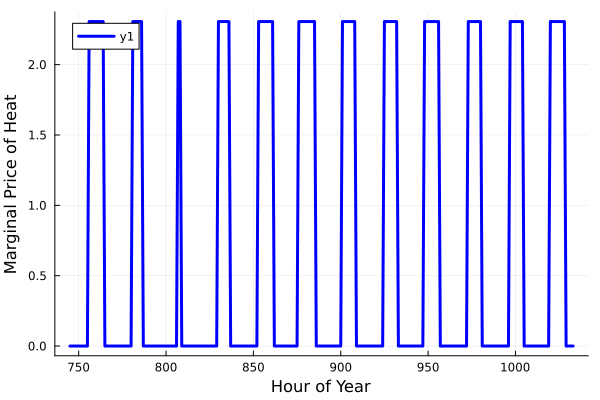

In [28]:
p = plot(; xlabel="Hour of Year", ylabel="Marginal Price of Heat")
# p = plot(; xlabel="Time", ylabel=["The function ", L"y = 2x + 1", " is\\affine and not linear"])
# add simulated solution
plot!(p, T[745:1033], -heating_price.data[745:1033], linewidth=3, color=:blue)

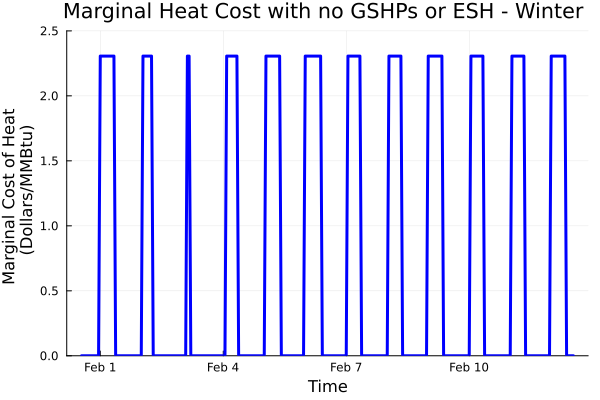

In [29]:
x_labels = ["Feb 1", "Feb 4", "Feb 7", "Feb 10", "Feb 12"]
p = plot()

plot!( -heating_price.data[745:1033], linewidth=3, color=:blue, xlabel="Time", xticks=(12:72:288, x_labels), ylabel="Marginal Cost of Heat \n (Dollars/MMBtu)", ylimit = (0,2.5),legend = false,title="Marginal Heat Cost with no GSHPs or ESH - Winter ")
plot!(xticks=(12:72:288, x_labels))
# Customize the x-axis labels


# plot!(legend=:topright, legendcolumns=1, title="Electricity with no GSHPs or ESH - Winter ", topmargin=5mm, leftmargin=5mm, bottommargin=5mm)
# plot!(p, size=(800, 450))


# p = plot(; xlabel="Time", ylabel=["The function ", L"y = 2x + 1", " is\\affine and not linear"])
# add simulated solution


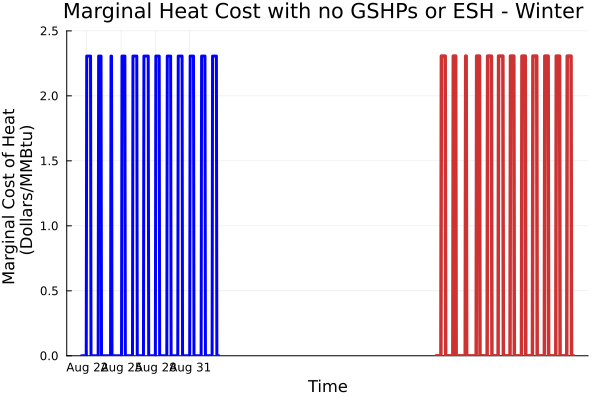

In [30]:
# THis is the plot of electricity generation with heat pumps so demand is higher
# remake for more hours
x_labels = ["Aug 22", "Aug 25", "Aug 28", "Aug 31", "Sept 3"]

gen = value.(y).data 
# p = areaplot(gen'[5593:5881,:], 
#     label=["Natural Gas" "Solar"], 
#     xlabel = "Time", 
#     ylabel ="Generated Electricity (MW)", 
#     color_palette=[:slateblue4, :goldenrod],
#     grid=:false,
#     # ylim=(0, 100),
# )

plot!(T[745:1033], -heating_price.data[745:1033], label="Electricity Demand", color=:brown3, linewidth=3.5)
plot!(xticks=(12:72:288, x_labels))

# plot!(legend=:topleft, legendcolumns=1, title="Electricity Summer no GSHPs or ESH", topmargin=5mm, leftmargin=5mm, bottommargin=5mm)
# plot!(p, size=(800, 450))

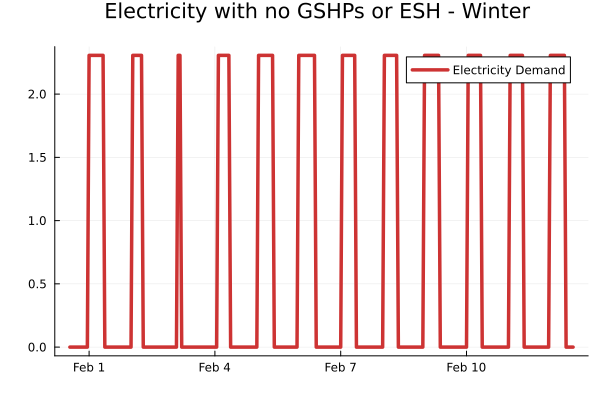

In [31]:
p = plot()
x_labels = ["Feb 1", "Feb 4", "Feb 7", "Feb 10", "Feb 12"]
# THis is the plot of electricity generation with heat pumps so demand is higher
# remake for more hours
gen = value.(y).data 
# p = areaplot(gen'[745:1033,:], 
#     label=["Natural Gas" "Solar"], 
#     xlabel = "Time", 
#     ylabel ="Generated Electricity (MW)", 
#     color_palette=[:slateblue4, :goldenrod],
#     grid=:false,
#     # ylim=(0, 100),
# )
plot!(-heating_price.data[745:1033], label="Electricity Demand", color=:brown3, linewidth=3.5)
# Customize the x-axis labels
plot!(xticks=(12:72:288, x_labels))

plot!(legend=:topright, legendcolumns=1, title="Electricity with no GSHPs or ESH - Winter ", topmargin=5mm, leftmargin=5mm, bottommargin=5mm)
# plot!(p, size=(800, 450))

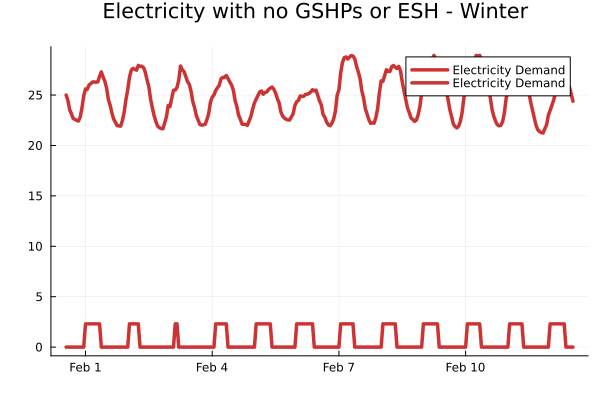

In [32]:
plot!(edemand.edemand[745:1033, :], label="Electricity Demand", color=:brown3, linewidth=3.5)
# Customize the x-axis labels
plot!(xticks=(12:72:288, x_labels))

plot!(legend=:topright, legendcolumns=1, title="Electricity with no GSHPs or ESH - Winter ", topmargin=5mm, leftmargin=5mm, bottommargin=5mm)
# plot!(p, size=(800, 450))

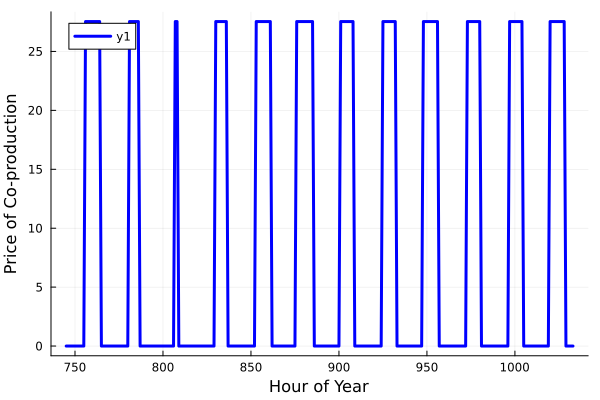

In [33]:
p = plot(; xlabel="Hour of Year", ylabel="Price of Co-production")
# p = plot(; xlabel="Time", ylabel=["The function ", L"y = 2x + 1", " is\\affine and not linear"])
# add simulated solution
plot!(p, T[745:1033], -chp_price.data[745:1033], linewidth=3, color=:blue)

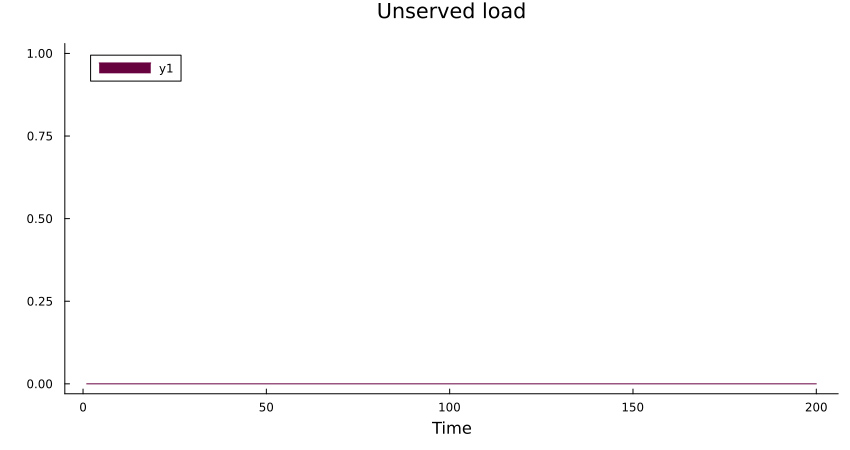

In [34]:
# THis is the plot of electricity generation with heat pumps so demand is higher
# constraint to meet both electricity and heat demand

# remake for more hours
nsh = value.(NSH).data 
p = areaplot(nsh[1:200,:], 
    # label=["Natural Gas" "Solar"], 
    xlabel = "Time", 
    # ylabel ="Generated Electricity (MW)", 
    color_palette=:mk_15,
    grid=:false,
    # ylim=(0, 100),
)
plot!(legend=:topleft, legendcolumns=1, title="Unserved load", topmargin=5mm, leftmargin=5mm, bottommargin=5mm)
plot!(p, size=(850, 450))

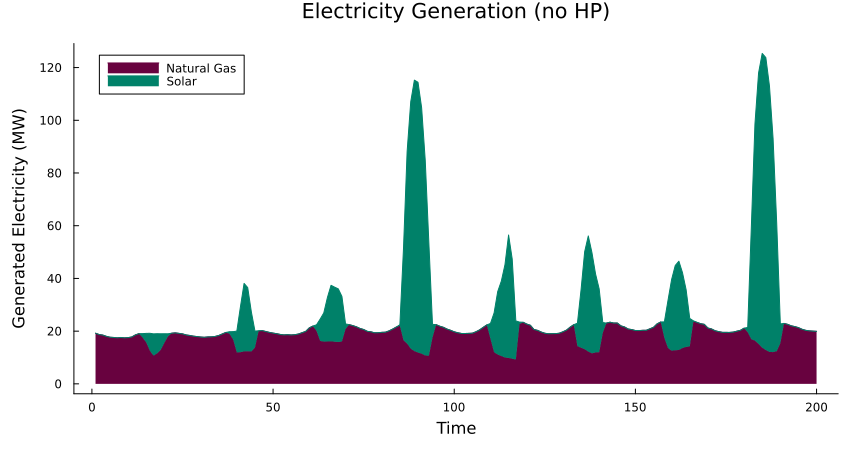

In [35]:
# THis is the plot of electricity generation with heat pumps so demand is higher
# constraint to meet both electricity and heat demand

# remake for more hours
gen = value.(y).data 
p = areaplot(gen'[1:200,:], 
    label=["Natural Gas" "Solar"], 
    xlabel = "Time", 
    ylabel ="Generated Electricity (MW)", 
    color_palette=:mk_15,
    grid=:false,
    # ylim=(0, 100),
)
plot!(legend=:topleft, legendcolumns=1, title="Electricity Generation (no HP)", topmargin=5mm, leftmargin=5mm, bottommargin=5mm)
plot!(p, size=(850, 450))

In [36]:
value.(y).data 

2×8736 Matrix{Float64}:
 19.2144  18.705  18.5034  18.0225  …  17.3802  19.0662  19.1818  18.9005
 -0.0     -0.0    -0.0     -0.0         1.518   -0.0     -0.0     -0.0

In [37]:
# THis is the plot of electricity generation with heat pumps so demand is higher
# remake for more hours
x_labels = ["Aug 22", "Aug 25", "Aug 28", "Aug 31", "Sept 3"]

gen = value.(y).data 
p = areaplot(gen'[5593:5881,:], 
    label=["Natural Gas" "Solar"], 
    xlabel = "Time", 
    ylabel ="Generated Electricity (MW)", 
    color_palette=[:slateblue4, :goldenrod],
    grid=:false,
    # ylim=(0, 100),
)

plot!(p, edemand.edemand[5593:5881, :], label="Electricity Demand", color=:brown3, linewidth=3.5)
plot!(xticks=(12:72:288, x_labels))

plot!(legend=:topleft, legendcolumns=1, title="Electricity with no GSHPs or ESH - Summer", topmargin=5mm, leftmargin=5mm, bottommargin=5mm)
plot!(p, size=(800, 450))
savefig("Elec2_Summer.png")

"c:\\Users\\fenya\\Documents\\BEE4750\\Project\\FP-Group6\\Elec2_Summer.png"

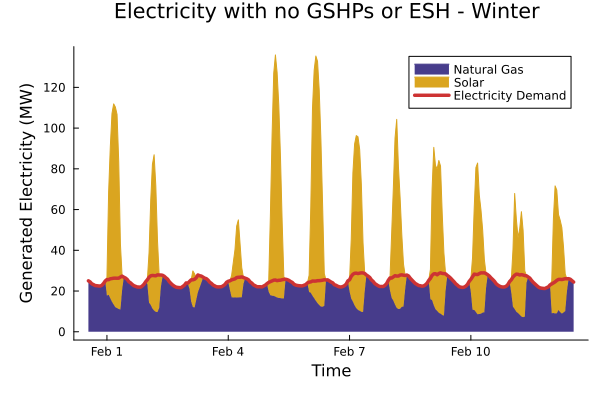

In [38]:
x_labels = ["Feb 1", "Feb 4", "Feb 7", "Feb 10", "Feb 12"]
# THis is the plot of electricity generation with heat pumps so demand is higher
# remake for more hours
gen = value.(y).data 
p = areaplot(gen'[745:1033,:], 
    label=["Natural Gas" "Solar"], 
    xlabel = "Time", 
    ylabel ="Generated Electricity (MW)", 
    color_palette=[:slateblue4, :goldenrod],
    grid=:false,
    # ylim=(0, 100),
)

plot!(p, edemand.edemand[745:1033, :], label="Electricity Demand", color=:brown3, linewidth=3.5)
# Customize the x-axis labels
plot!(xticks=(12:72:288, x_labels))

plot!(legend=:topright, legendcolumns=1, title="Electricity with no GSHPs or ESH - Winter ", topmargin=5mm, leftmargin=5mm, bottommargin=5mm)
# plot!(p, size=(800, 450))

In [39]:
stop

UndefVarError: UndefVarError: `stop` not defined

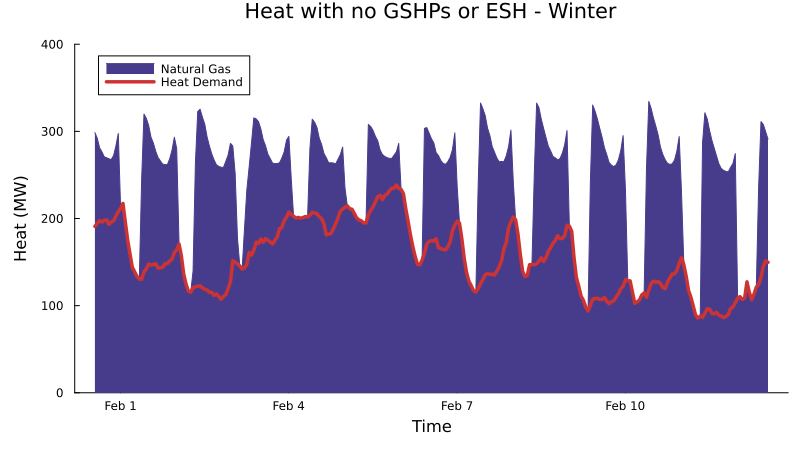

In [40]:
# Optimized cost with meeting electricity and heat demand
# remake for more hours
x_labels = ["Feb 1", "Feb 4", "Feb 7", "Feb 10", "Feb 12"]

# x_labels = ["", "", "", "", "","", "", "", "", "", "", ""]

heat_data = value.(z).data 
p = areaplot(heat_data'[745:1033,:], 
    label="Natural Gas", 
    xlabel = "Time", 
    ylabel ="Heat (MW)",
    xticks = (1:12), 
    color_palette=[:slateblue4, :goldenrod],
    grid=:false,
    ylim=(0, 400),
)
plot!(p, hdemand.hdemand[745:1033, :], label="Heat Demand", color=:brown3, linewidth=3.5)
# plot!(xticks=(12:72:288, x_labels))
plot!(xticks=(12:72:288, x_labels))

plot!(legend=:topleft, legendcolumns=1, title="Heat with no GSHPs or ESH - Winter", topmargin=5mm, leftmargin=5mm, bottommargin=5mm)
plot!(p, size=(800, 450))

In [41]:
# Optimized cost with meeting electricity and heat demand
# remake for more hours
x_labels = ["Aug 22", "Aug 25", "Aug 28", "Aug 31", "Sept 3"]

# x_labels = ["", "", "", "", "","", "", "", "", "", "", ""]

heat_data = value.(z).data 
p = areaplot(heat_data'[5593:5881,:], 
    label="Natural Gas", 
    xlabel = "Time", 
    ylabel ="Heat (MW)",
    xticks = (1:12), 
    color_palette=[:slateblue4, :goldenrod],
    grid=:false,
    ylim=(0, 400),
)
plot!(p, hdemand.hdemand[5593:5881, :], label="Heat Demand", color=:brown3, linewidth=3.5)
# plot!(xticks=(12:72:288, x_labels))
plot!(xticks=(12:72:288, x_labels))

plot!(legend=:topleft, legendcolumns=1, title="Heat with no GSHPs or ESH - Summer", topmargin=5mm, leftmargin=5mm, bottommargin=5mm)
plot!(p, size=(800, 450))
savefig("Heat2_Summer.png")

"c:\\Users\\fenya\\Documents\\BEE4750\\Project\\FP-Group6\\Heat2_Summer.png"

## Optimize for Emissions

In [42]:
# Optimizing cost of production for electricity and heat - no heat pumps
# define sets
G = 1:nrow(gens)
H = 1:1
T = 1:nrow(edemand)
NSECost = 10000
NSHCost = 5000

gencap = Model(HiGHS.Optimizer)
# define variables
@variables(gencap, begin
    y[g in G, t in T] >= 0
    z[h in H, t in T] >= 0
    NSE[t in T] >= 0
    NSH[t in T] >= 0
end)

@objective(gencap, Min, 
   sum(gens[G, :Emissions] .* sum(y[:, t] for t in T))
)

# @constraint(gencap, load[t in T], sum(y[:, t]) + NSE[t] >= edemand.edemand[t])
@constraint(gencap, load[t in T], sum(y[:, t]) >= edemand.edemand[t])
@constraint(gencap, heating[t in T], sum(z[:, t])  >= hdemand.hdemand[t])
# @constraint(gencap, chp[t in T], y[1, t] >= heat[1, :Conversion_Factor]*z[1, t] )
# @constraint(gencap, chpL[t in T], y[1, t] == 0.083752094*z[1, t] )
@constraint(gencap, chp[t in T], y[1, t] == heat[1, :Conversion_Factor]*z[1, t] )

@constraint(gencap, availability[g in G, t in T], y[g, t] <= gens[g, :Capacity]*cap_factor[t,g])
optimize!(gencap)

Running HiGHS 1.8.1 (git hash: 4a7f24ac6): Copyright (c) 2024 HiGHS under MIT licence terms
Coefficient ranges:
  Matrix [8e-02, 1e+00]
  Cost   [6e-01, 6e-01]
  Bound  [0e+00, 0e+00]
  RHS    [3e-05, 3e+02]
Presolving model
0 rows, 0 cols, 0 nonzeros  0s
0 rows, 0 cols, 0 nonzeros  0s
Presolve : Reductions: rows 0(-43680); columns 0(-43680); elements 0(-61152) - Reduced to empty
Solving the original LP from the solution after postsolve
Model status        : Optimal
Objective value     :  7.8500196131e+04
Relative P-D gap    :  5.1904790876e-15
HiGHS run time      :          0.12


In [43]:
NoHP_emissions = @show objective_value(gencap)

objective_value(gencap) = 78500.19613105989


78500.19613105989

In [44]:
# Cost per unit of MWh 
chp_price = @show shadow_price.(chp)

shadow_price.(chp) = 1-dimensional DenseAxisArray{Float64,1,...} with index sets:
    Dimension 1, 1:8736
And data, a 8736-element Vector{Float64}:
 -0.0
 -0.0
 -0.0
 -0.0
 -0.0
 -0.0
 -0.0
 -0.0
 -0.0
 -0.0
 -0.0
 -0.0
 -0.0
 -0.0
 -0.0
 -0.0
 -0.0
 -0.0
 -0.0
 -0.0
 -0.0
 -0.0
 -0.0
 -0.0
 -0.0
 -0.0
 -0.0
 -0.0
 -0.0
 -0.0
 -0.0
 -0.0
 -0.0
 -0.0
 -0.0
 -0.0
 -0.0
 -0.0
 -0.0
 -0.575830892
 -0.575830892
 -0.575830892
 -0.575830892
 -0.575830892
 -0.0
 -0.0
 -0.0
 -0.0
 -0.0
 -0.0
 -0.0
 -0.0
 -0.0
 -0.0
 -0.0
 -0.0
 -0.0
 -0.0
 -0.0
 -0.0
 -0.0
 -0.0
 -0.575830892
 -0.575830892
 -0.575830892
 -0.575830892
 -0.575830892
 -0.575830892
 -0.575830892
 -0.0
 -0.0
 -0.0
 -0.0
 -0.0
 -0.0
 -0.0
 -0.0
 -0.0
 -0.0
 -0.0
 -0.0
 -0.0
 -0.0
 -0.0
 -0.0
 -0.575830892
 -0.575830892
 -0.575830892
 -0.575830892
 -0.575830892
 -0.575830892
 -0.575830892
 -0.575830892
 -0.0
 -0.0
 -0.0
 -0.0
 -0.0
 -0.0
 -0.0
 -0.0
 -0.0
 -0.0
 -0.0
 -0.0
 -0.0
 -0.0
 -0.0
 -0.0
 -0.0
 -0.575830892
 -0.575830892
 -0.

1-dimensional DenseAxisArray{Float64,1,...} with index sets:
    Dimension 1, 1:8736
And data, a 8736-element Vector{Float64}:
 -0.0
 -0.0
 -0.0
 -0.0
 -0.0
 -0.0
 -0.0
 -0.0
 -0.0
 -0.0
  ⋮
 -0.575830892
 -0.575830892
 -0.575830892
 -0.0
 -0.0
 -0.0
 -0.0
 -0.0
 -0.0

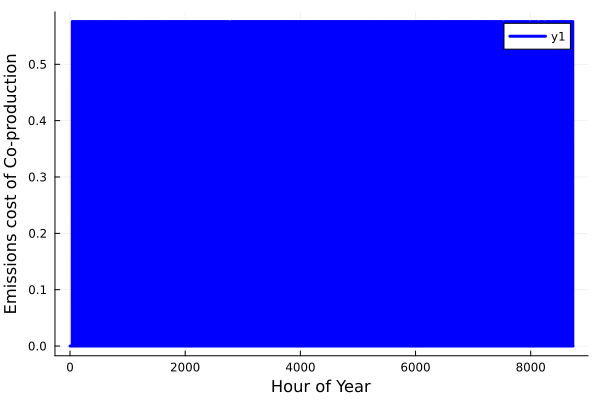

In [45]:
p = plot(; xlabel="Hour of Year", ylabel="Emissions cost of Co-production")
# p = plot(; xlabel="Time", ylabel=["The function ", L"y = 2x + 1", " is\\affine and not linear"])
# add simulated solution
plot!(p, T, -chp_price.data, linewidth=3, color=:blue)

## Natural Gas, Solar, & Heat Pumps

In [46]:
# define sets
G = 1:nrow(gens)
H = 1:2
T = 1:nrow(edemand)
NSECost = 10000
NSHCost = 5000

gencap = Model(HiGHS.Optimizer)
# define variables
@variables(gencap, begin
    y[g in G, t in T] >= 0
    z[h in H, t in T] >= 0
    NSE[t in T] >= 0
    NSH[t in T] >= 0
end)

@objective(gencap, Min, 
   sum(gens[G, :VarCost] .* sum(y[:, t] for t in T)) + NSECost * sum(NSE) + NSHCost * sum(NSH)
)

# @constraint(gencap, load[t in T], sum(y[:, t]) + NSE[t] >= edemand.edemand[t])
@constraint(gencap, load[t in T], sum(y[:, t]) + NSE[t] >= edemand.edemand[t]+ heat[2, :Conversion_Factor]*z[2, t])
@constraint(gencap, heating[t in T], sum(z[:, t]) + NSH[t] >= hdemand.hdemand[t])
# @constraint(gencap, chpL[t in T], 0.058223683*z[1, t] <=  y[1, t] )
# @constraint(gencap, chpU[t in T], y[1, t] <= 0.66694584*z[1, t] )
# @constraint(gencap, chp[t in T], y[1, t] >= heat[1, :Conversion_Factor]*z[1, t] )
@constraint(gencap, chp[t in T], y[1, t] == heat[1, :Conversion_Factor]*z[1, t] )

@constraint(gencap, availability[g in G, t in T], y[g, t] <= gens[g, :Capacity]*cap_factor[t,g])
optimize!(gencap)

Running HiGHS 1.8.1 (git hash: 4a7f24ac6): Copyright (c) 2024 HiGHS under MIT licence terms
Coefficient ranges:
  Matrix [8e-02, 1e+00]
  Cost   [3e+01, 1e+04]
  Bound  [0e+00, 0e+00]
  RHS    [3e-05, 3e+02]
Presolving model
17420 rows, 34840 cols, 52208 nonzeros  0s
17399 rows, 34798 cols, 52166 nonzeros  0s
Presolve : Reductions: rows 17399(-26281); columns 34798(-17618); elements 52166(-43930)
Solving the presolved LP
Using EKK dual simplex solver - serial
  Iteration        Objective     Infeasibilities num(sum)
          0     0.0000000000e+00 Pr: 14677(657696) 0s
       9411     3.2769323567e+06 Pr: 0(0) 0s
Solving the original LP from the solution after postsolve
Model status        : Optimal
Simplex   iterations: 9411
Objective value     :  3.2769323567e+06
Relative P-D gap    :  3.4104673759e-15
HiGHS run time      :          0.37


In [47]:
heating_price = @show shadow_price.(heating)

shadow_price.(heating) = 1-dimensional DenseAxisArray{Float64,1,...} with index sets:
    Dimension 1, 1:8736
And data, a 8736-element Vector{Float64}:
 -0.0
 -0.0
 -0.0
 -0.0
 -0.0
 -0.0
 -0.0
 -0.0
 -0.0
 -0.0
 -0.0
 -0.0
 -0.0
 -0.0
 -0.0
 -0.0
 -0.0
 -0.0
 -0.0
 -0.0
 -0.0
 -0.0
 -0.0
 -0.0
 -0.0
 -0.0
 -0.0
 -0.0
 -0.0
 -0.0
 -0.0
 -0.0
 -0.0
 -0.0
 -0.0
 -0.0
 -0.0
 -0.0
 -0.0
 -1.136676979591244
 -1.136676979591244
 -1.136676979591244
 -1.136676979591244
 -1.136676979591244
 -0.0
 -0.0
 -0.0
 -0.0
 -0.0
 -0.0
 -0.0
 -0.0
 -0.0
 -0.0
 -0.0
 -0.0
 -0.0
 -0.0
 -0.0
 -0.0
 -0.0
 -0.0
 -1.136676979591244
 -1.136676979591244
 -1.136676979591244
 -1.136676979591244
 -1.136676979591244
 -1.136676979591244
 -1.136676979591244
 -0.0
 -0.0
 -0.0
 -0.0
 -0.0
 -0.0
 -0.0
 -0.0
 -0.0
 -0.0
 -0.0
 -0.0
 -0.0
 -0.0
 -0.0
 -0.0
 -1.136676979591244
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
 -0.0
 -0.0
 -0.0
 -0.0
 -0.0
 -0.0
 -0.0
 -0.0
 -0.0
 -0.0
 -0.0
 -0.0
 -0.0
 -0.0
 -0.0
 -0.0
 -0.0
 -1.13

1-dimensional DenseAxisArray{Float64,1,...} with index sets:
    Dimension 1, 1:8736
And data, a 8736-element Vector{Float64}:
 -0.0
 -0.0
 -0.0
 -0.0
 -0.0
 -0.0
 -0.0
 -0.0
 -0.0
 -0.0
  ⋮
 -1.136676979591244
 -1.136676979591244
 -1.136676979591244
 -0.0
 -0.0
 -0.0
 -0.0
 -0.0
 -0.0

In [48]:
HP_cost = @show objective_value(gencap)

objective_value(gencap) = 3.2769323566925195e6


3.2769323566925195e6

In [49]:
heat_prod = @show value.(z)

Excessive output truncated after 647573 bytes.

value.(z) = 

2-dimensional DenseAxisArray{Float64,2,...} with index sets:
    Dimension 1, 1:2
    Dimension 2, 1:8736
And data, a 2×8736 Matrix{Float64}:
 229.419  223.338  220.931  215.189  …  207.52  227.65  229.031  225.672
   0.0      0.0      0.0      0.0         0.0     0.0     0.0      0.0

In [50]:
elec_prod = @show value.(y)

2-dimensional DenseAxisArray{Float64,2,...} with index sets:
    Dimension 1, 1:2
    Dimension 2, 1:8736
And data, a 2×8736 Matrix{Float64}:
 19.2144  18.705  18.5034  18.0225  …  17.3802  19.0662  19.1818  18.9005
 -0.0     -0.0    -0.0     -0.0         1.518   -0.0     -0.0     -0.0

In [51]:
value.(z)[2, 5593:5881].data

289-element Vector{Float64}:
  0.0
  0.0
  0.0
  0.0
  0.0
  0.9826035192208145
 47.8336101
 46.379100195
 42.822162254999995
 40.891153815
  ⋮
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0

In [52]:
# THis is the plot of electricity generation with heat pumps so demand is higher
# remake for more hours
x_labels = ["Aug 22", "Aug 25", "Aug 28", "Aug 31", "Sept 3"]

gen = value.(y).data 
p = areaplot(gen'[5593:5881,:], 
    label=["Natural Gas" "Solar"], 
    xlabel = "Time", 
    ylabel ="Generated Electricity (MW)", 
    color_palette=[:slateblue4, :goldenrod],
    grid=:false,
    # ylim=(0, 100),
)

plot!(p, edemand.edemand[5593:5881, :]+ heat[2, :Conversion_Factor]*value.(z)[2, 5593:5881].data, label="Electricity Demand (including GSHP demand)", color=:brown3, linewidth=3.5)
plot!(xticks=(12:72:288, x_labels))

plot!(legend=:topleft, legendcolumns=1, title="Electricity with GSHPs - Summer", topmargin=5mm, leftmargin=5mm, bottommargin=5mm)
plot!(p, size=(800, 450))
savefig("elec3_summer.png")

"c:\\Users\\fenya\\Documents\\BEE4750\\Project\\FP-Group6\\elec3_summer.png"

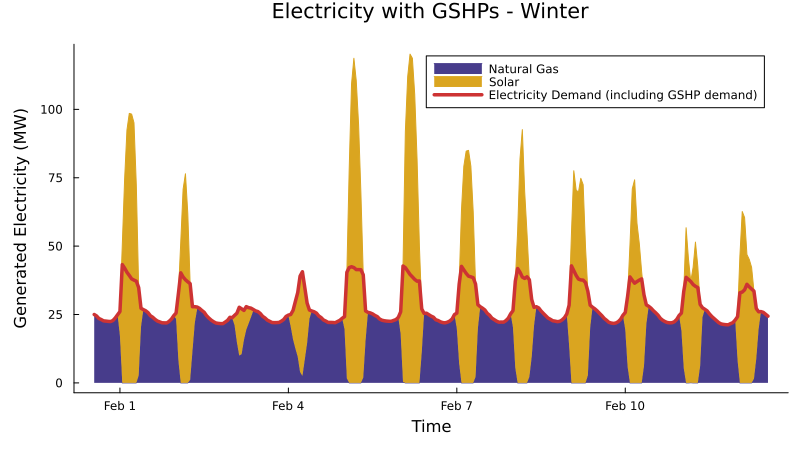

In [53]:
# THis is the plot of electricity generation with heat pumps so demand is higher

x_labels = ["Feb 1", "Feb 4", "Feb 7", "Feb 10", "Feb 12"]
# remake for more hours
gen = value.(y).data 
p = areaplot(gen'[745:1033,:], 
    label=["Natural Gas" "Solar"], 
    xlabel = "Time", 
    ylabel ="Generated Electricity (MW)", 
    color_palette=[:slateblue4, :goldenrod],
    grid=:false,
    # ylim=(0, 100),
)

plot!(p, edemand.edemand[745:1033, :]+ heat[2, :Conversion_Factor]*value.(z)[2, 745:1033].data,  label="Electricity Demand (including GSHP demand)", color=:brown3, linewidth=3.5)
# Customize the x-axis labels
plot!(xticks=(12:72:288, x_labels))

plot!(legend=:topright, legendcolumns=1, title="Electricity with GSHPs - Winter", topmargin=5mm, leftmargin=5mm, bottommargin=5mm)
plot!(p, size=(800, 450))

In [54]:
stop

UndefVarError: UndefVarError: `stop` not defined

### Looking at Electricity & Heat

In [55]:
# Optimized cost with meeting electricity and heat demand
# remake for more hours
x_labels = ["Aug 22", "Aug 25", "Aug 28", "Aug 31", "Sept 3"]


heat_data = value.(z).data 
p = areaplot(heat_data'[5593:5881,:], 
    label=["Natural Gas" "Ground Source Heat Pumps"], 
    xlabel = "Time", 
    ylabel ="Heat (MW)", 
    color_palette=[:slateblue4, :goldenrod],
    grid=:false,
    # ylim=(0, 100),
)

plot!(p, hdemand.hdemand[5593:5881, :], label="Heat Demand", color=:brown3, linewidth=3.5)
plot!(xticks=(12:72:288, x_labels))

plot!(legend=:topleft, legendcolumns=1, title="Heat with GSHPs - Summer", topmargin=5mm, leftmargin=5mm, bottommargin=5mm)
plot!(p, size=(800, 450))
savefig("Heat3_Summer.png")

"c:\\Users\\fenya\\Documents\\BEE4750\\Project\\FP-Group6\\Heat3_Summer.png"

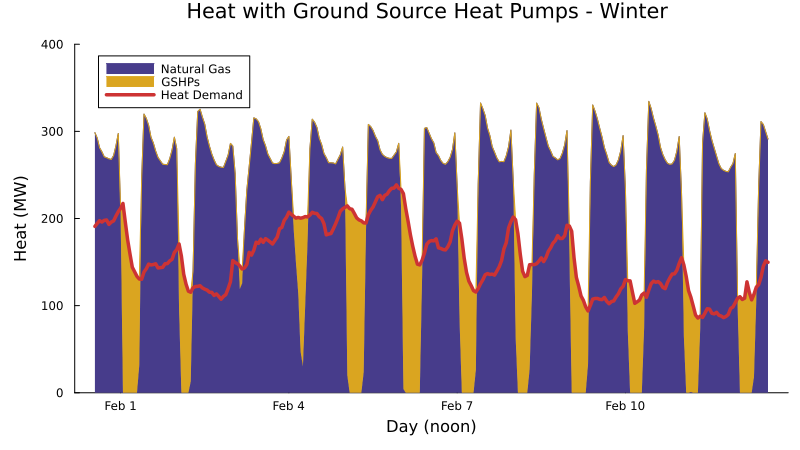

In [26]:
# Optimized cost with meeting electricity and heat demand
# remake for more hours
x_labels = ["Feb 1", "Feb 4", "Feb 7", "Feb 10", "Feb 12"]

heat_data = value.(z).data 
p = areaplot(heat_data'[745:1033,:],
    label=["Natural Gas" "GSHPs"], 
    xlabel = "Day (noon)", 
    ylabel ="Heat (MW)", 
    color_palette=[:slateblue4, :goldenrod],
    grid=:false,
    ylim=(0, 400),
)

plot!(p, hdemand.hdemand[745:1033, :], label="Heat Demand", color=:brown3, linewidth=3.5)
plot!(xticks=(12:72:288, x_labels))
 
plot!(legend=:topleft, legendcolumns=1, title="Heat with GSHPs - Winter ", topmargin=5mm, leftmargin=5mm, bottommargin=5mm)
plot!(p, size=(800, 450))

In [ ]:
@show value(sum(NSE));

In [ ]:
chp_price = @show shadow_price.(chp)

In [ ]:
maximum(-chp_price.data)

In [ ]:
chp_price.data[745:1033]

In [ ]:
[745:1033, :]

In [ ]:
p = plot(; xlabel="Hour of Year", ylabel="Price of Co-production")
# p = plot(; xlabel="Time", ylabel=["The function ", L"y = 2x + 1", " is\\affine and not linear"])
# add simulated solution
plot!(p, T, -chp_price.data, linewidth=3, color=:blue)

In [ ]:
x_labels = ["Feb 1", "Feb 4", "Feb 7", "Feb 10", "Feb 12"]
p = plot()

plot!( -heating_price.data[745:1033], linewidth=3, color=:blue, xlabel="Time", xticks=(12:72:288, x_labels), ylabel="Marginal Cost of Heat \n (Dollars/MMBtu)", ylimit = (0,2.5),legend = false, title="Marginal Heat Cost with GSHPs - Winter ")
plot!(xticks=(12:72:288, x_labels))
# Customize the x-axis labels


# plot!(legend=:topright, legendcolumns=1, title="Electricity with no GSHPs or ESH - Winter ", topmargin=5mm, leftmargin=5mm, bottommargin=5mm)
# plot!(p, size=(800, 450))


# p = plot(; xlabel="Time", ylabel=["The function ", L"y = 2x + 1", " is\\affine and not linear"])
# add simulated solution


## Optimize for Emissions

In [ ]:
# define sets
G = 1:nrow(gens)
H = 1:2
T = 1:nrow(edemand)
NSECost = 10000
NSHCost = 5000

gencap = Model(HiGHS.Optimizer)
# define variables
@variables(gencap, begin
    y[g in G, t in T] >= 0
    z[h in H, t in T] >= 0
end)

@objective(gencap, Min, 
   sum(gens[G, :Emissions] .* sum(y[:, t] for t in T))
)

# @constraint(gencap, load[t in T], sum(y[:, t]) + NSE[t] >= edemand.edemand[t])
@constraint(gencap, load[t in T], sum(y[:, t])>= edemand.edemand[t]+ heat[2, :Conversion_Factor]*z[2, t])
@constraint(gencap, heating[t in T], sum(z[:, t]) >= hdemand.hdemand[t])
# @constraint(gencap, chpL[t in T], 0.058223683*z[1, t] <=  y[1, t] )
# @constraint(gencap, chpU[t in T], y[1, t] <= 0.66694584*z[1, t] )
# @constraint(gencap, chp[t in T], y[1, t] >= heat[1, :Conversion_Factor]*z[1, t] )
@constraint(gencap, chp[t in T], y[1, t] == heat[1, :Conversion_Factor]*z[1, t] )

@constraint(gencap, availability[g in G, t in T], y[g, t] <= gens[g, :Capacity]*cap_factor[t,g])
optimize!(gencap)

In [ ]:
HP_emissions = @show objective_value(gencap)

In [ ]:
heat_prod = @show value.(z)

In [ ]:
elec_prod = @show value.(y)

In [ ]:
# THis is the plot of electricity generation with heat pumps so demand is higher
# remake for more hours
gen = value.(y).data 
p = areaplot(gen'[1:200,:], 
    label=["Natural Gas" "Solar"], 
    xlabel = "Time", 
    ylabel ="Generated Electricity (MW)", 
    color_palette=:mk_15,
    grid=:false,
    # ylim=(0, 100),
)
plot!(legend=:topleft, legendcolumns=1, title="Electricity Generation with GSHP", topmargin=5mm, leftmargin=5mm, bottommargin=5mm)
plot!(p, size=(850, 450))

In [ ]:
# Optimized cost with meeting electricity and heat demand
# remake for more hours
heat_data = value.(z).data 
p = areaplot(heat_data'[1:200,:], 
    label=["Natural Gas" "Ground Source Heat Pumps"], 
    xlabel = "Time", 
    ylabel ="Heat (MW)", 
    color_palette=:mk_15,
    grid=:false,
    # ylim=(0, 100),
)
plot!(legend=:topleft, legendcolumns=1, title="Heat Power", topmargin=5mm, leftmargin=5mm, bottommargin=5mm)
plot!(p, size=(850, 450))

In [ ]:
# Optimized cost with meeting electricity and heat demand
# remake for more hours
heat_data = value.(z).data 
p = areaplot(heat_data', 
    label=["Natural Gas" "Ground Source Heat Pumps"], 
    xlabel = "Time", 
    ylabel ="Heat (MW)", 
    color_palette=:mk_15,
    grid=:false,
    # ylim=(0, 100),
)
plot!(legend=:topleft, legendcolumns=1, title="Heat Power", topmargin=5mm, leftmargin=5mm, bottommargin=5mm)
plot!(p, size=(850, 450))

In [ ]:
@show value(sum(NSE));

In [ ]:
chp_price = @show shadow_price.(chp)

In [ ]:
chp_price.data[745:1033]

In [ ]:
maximum(-chp_price.data)

In [ ]:
p = plot(; xlabel="Hour of Year", ylabel="Price of Co-production")
# p = plot(; xlabel="Time", ylabel=["The function ", L"y = 2x + 1", " is\\affine and not linear"])
# add simulated solution
plot!(p, T[745:1033], -chp_price.data[745:1033], linewidth=3, color=:blue)

## Natural Gas, Solar, & ESH (no GSHPs)

### Looking at Electricity & Heat

In [29]:
heat = heat[[1,3],:]
# define sets
G = 1:nrow(gens)
H = 1:2
T = 1:nrow(edemand)
NSECost = 10000
NSHCost = 5000

gencap = Model(HiGHS.Optimizer)
# define variables
@variables(gencap, begin
    y[g in G, t in T] >= 0
    z[h in H, t in T] >= 0
    NSE[t in T] >= 0
    NSH[t in T] >= 0
end)

@objective(gencap, Min, 
   sum(gens[G, :VarCost] .* sum(y[:, t] for t in T)) + NSECost * sum(NSE) + NSHCost * sum(NSH)
)

# @constraint(gencap, load[t in T], sum(y[:, t]) + NSE[t] >= edemand.edemand[t])
@constraint(gencap, load[t in T], sum(y[:, t]) + NSE[t] >= edemand.edemand[t]+ heat[2, :Conversion_Factor]*z[2, t])
@constraint(gencap, heating[t in T], sum(z[:, t]) + NSH[t] >= hdemand.hdemand[t])
# @constraint(gencap, chpL[t in T], 0.058223683*z[1, t] <=  y[1, t] )
# @constraint(gencap, chpU[t in T], y[1, t] <= 0.66694584*z[1, t] )
# @constraint(gencap, chp[t in T], y[1, t] >= heat[1, :Conversion_Factor]*z[1, t] )
@constraint(gencap, chp[t in T], y[1, t] == heat[1, :Conversion_Factor]*z[1, t] )

@constraint(gencap, availability[g in G, t in T], y[g, t] <= gens[g, :Capacity]*cap_factor[t,g])
optimize!(gencap)

Running HiGHS 1.8.1 (git hash: 4a7f24ac6): Copyright (c) 2024 HiGHS under MIT licence terms
Coefficient ranges:
  Matrix [3e-02, 1e+00]
  Cost   [3e+01, 1e+04]
  Bound  [0e+00, 0e+00]
  RHS    [3e-05, 3e+02]
Presolving model
17420 rows, 34840 cols, 52208 nonzeros  0s
17399 rows, 34798 cols, 52166 nonzeros  0s
Presolve : Reductions: rows 17399(-26281); columns 34798(-17618); elements 52166(-43930)
Solving the presolved LP
Using EKK dual simplex solver - serial
  Iteration        Objective     Infeasibilities num(sum)
          0     0.0000000000e+00 Pr: 14677(657696) 0s
       9206     3.2466060880e+06 Pr: 0(0) 0s
Solving the original LP from the solution after postsolve
Model status        : Optimal
Simplex   iterations: 9206
Objective value     :  3.2466060880e+06
Relative P-D gap    :  8.6058106468e-16
HiGHS run time      :          0.35


In [ ]:
ESH_cost = @show objective_value(gencap)

In [ ]:
heating_price = @show shadow_price.(heating)

In [ ]:
x_labels = ["Feb 1", "Feb 4", "Feb 7", "Feb 10", "Feb 12"]
p = plot()

plot!( -heating_price.data[745:1033], linewidth=3, color=:blue, xlabel="Time", xticks=(12:72:288, x_labels), ylabel="Marginal Cost of Heat \n (Dollars/MMBtu)", ylimit = (0,2.5),legend = false, title="Marginal Heat Cost with ESH - Winter ")
plot!(xticks=(12:72:288, x_labels))
# Customize the x-axis labels


# plot!(legend=:topright, legendcolumns=1, title="Electricity with no GSHPs or ESH - Winter ", topmargin=5mm, leftmargin=5mm, bottommargin=5mm)
# plot!(p, size=(800, 450))


# p = plot(; xlabel="Time", ylabel=["The function ", L"y = 2x + 1", " is\\affine and not linear"])
# add simulated solution


In [ ]:
heat_prod = @show value.(z)

In [ ]:
elec_prod = @show value.(y)

In [33]:
# THis is the plot of electricity generation with heat pumps so demand is higher
# remake for more hours
x_labels = ["Aug 22", "Aug 25", "Aug 28", "Aug 31", "Sept 3"]

gen = value.(y).data 
p = areaplot(gen'[5593:5881,:], 
    label=["Natural Gas" "Solar"], 
    xlabel = "Time", 
    ylabel ="Generated Electricity (MW)", 
    color_palette=[:slateblue4, :goldenrod],
    grid=:false,
    # ylim=(0, 100),
)

plot!(p, edemand.edemand[5593:5881, :]+ heat[2, :Conversion_Factor]*value.(z)[2, 5593:5881].data, label="Electricity Demand (including ESH demand)", color=:brown3, linewidth=3.5)
plot!(xticks=(12:72:288, x_labels))


plot!(legend=:topleft, legendcolumns=1, title="Electricity with ESH - Summer", topmargin=5mm, leftmargin=5mm, bottommargin=5mm)
plot!(p, size=(800, 450))
savefig("elec4_summer.png")

"c:\\Users\\fenya\\Documents\\BEE4750\\Project\\FP-Group6\\elec4_summer.png"

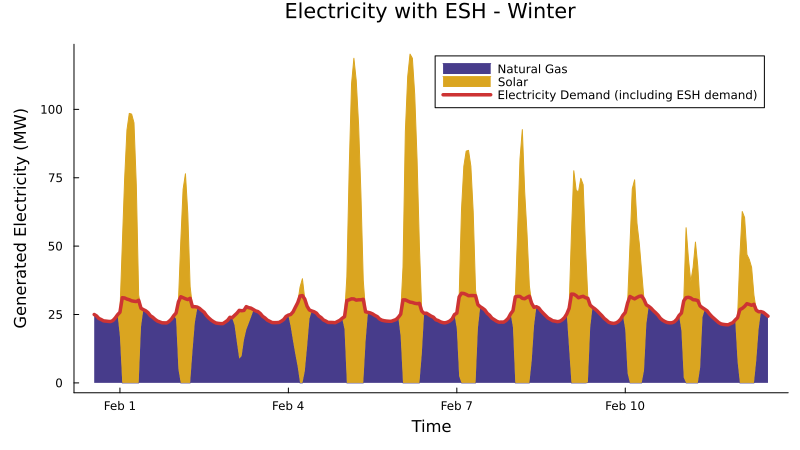

In [32]:
# THis is the plot of electricity generation with heat pumps so demand is higher
# remake for more hours
x_labels = ["Feb 1", "Feb 4", "Feb 7", "Feb 10", "Feb 12"]

gen = value.(y).data 
p = areaplot(gen'[745:1033,:], 
    label=["Natural Gas" "Solar"], 
    xlabel = "Time", 
    ylabel ="Generated Electricity (MW)", 
    color_palette=[:slateblue4, :goldenrod],
    grid=:false,
    # ylim=(0, 100),
)

plot!(p, edemand.edemand[745:1033, :]+ heat[2, :Conversion_Factor]*value.(z)[2, 745:1033].data,  label="Electricity Demand (including ESH demand)", color=:brown3, linewidth=3.5)
plot!(xticks=(12:72:288, x_labels))


plot!(legend=:topright, legendcolumns=1, title="Electricity with ESH - Winter", topmargin=5mm, leftmargin=5mm, bottommargin=5mm)
plot!(p, size=(800, 450))

In [35]:
# Optimized cost with meeting electricity and heat demand
# remake for more hours
x_labels = ["Aug 22", "Aug 25", "Aug 28", "Aug 31", "Sept 3"]

heat_data = value.(z).data 
p = areaplot(heat_data'[5593:5881,:], 
    label=["Natural Gas" "Ground Source Heat Pumps"], 
    xlabel = "Time", 
    ylabel ="Heat (MW)", 
    color_palette=[:slateblue4, :goldenrod],
    grid=:false,
    # ylim=(0, 100),
)
plot!(p, hdemand.hdemand[5593:5881, :], label="Heat Demand", color=:brown3, linewidth=3.5)
plot!(xticks=(12:72:288, x_labels))

plot!(legend=:topleft, legendcolumns=1, title="Heat with Earth Source Heat - Summer", topmargin=5mm, leftmargin=5mm, bottommargin=5mm)
plot!(p, size=(800, 450))
savefig("Heat4_summer.png")

"c:\\Users\\fenya\\Documents\\BEE4750\\Project\\FP-Group6\\Heat4_summer.png"

In [ ]:
# Optimized cost with meeting electricity and heat demand
# remake for more hours
x_labels = ["Feb 1", "Feb 4", "Feb 7", "Feb 10", "Feb 12"]

# x_labels = ["", "", "", "", "","", "", "", "", "", "", ""]

heat_data = value.(z).data 
p = areaplot(heat_data'[745:1033,:], 
    label=["Natural Gas" "ESH"], 
    xlabel = "Time", 
    ylabel ="Heat (MW)",
    xticks = (1:12), 
    color_palette=[:slateblue4, :goldenrod],
    grid=:false,
    ylim=(0, 400),
)
plot!(p, hdemand.hdemand[745:1033, :], label="Heat Demand", color=:brown3, linewidth=3.5)
# plot!(xticks=(12:72:288, x_labels))
plot!(xticks=(12:72:288, x_labels))

plot!(legend=:topleft, legendcolumns=1, title="Heat with Earth Source Heat - Winter", topmargin=5mm, leftmargin=5mm, bottommargin=5mm)
plot!(p, size=(800, 450))

In [ ]:
@show value(sum(NSE));

In [ ]:
chp_price = @show shadow_price.(chp)

In [ ]:
maximum(-chp_price.data)

In [ ]:
p = plot(; xlabel="Hour of Year", ylabel="Price of Co-production")
# p = plot(; xlabel="Time", ylabel=["The function ", L"y = 2x + 1", " is\\affine and not linear"])
# add simulated solution
plot!(p, T, -chp_price.data, linewidth=3, color=:blue)

## Optimize for Emissions

In [ ]:
# define sets
G = 1:nrow(gens)
H = 1:2
T = 1:nrow(edemand)
NSECost = 10000
NSHCost = 5000

gencap = Model(HiGHS.Optimizer)
# define variables
@variables(gencap, begin
    y[g in G, t in T] >= 0
    z[h in H, t in T] >= 0
end)

@objective(gencap, Min, 
   sum(gens[G, :Emissions] .* sum(y[:, t] for t in T))
)

# @constraint(gencap, load[t in T], sum(y[:, t]) + NSE[t] >= edemand.edemand[t])
@constraint(gencap, load[t in T], sum(y[:, t])>= edemand.edemand[t]+ heat[2, :Conversion_Factor]*z[2, t])
@constraint(gencap, heating[t in T], sum(z[:, t]) >= hdemand.hdemand[t])
# @constraint(gencap, chpL[t in T], 0.058223683*z[1, t] <=  y[1, t] )
# @constraint(gencap, chpU[t in T], y[1, t] <= 0.66694584*z[1, t] )
# @constraint(gencap, chp[t in T], y[1, t] >= heat[1, :Conversion_Factor]*z[1, t] )
@constraint(gencap, chp[t in T], y[1, t] == heat[1, :Conversion_Factor]*z[1, t] )

@constraint(gencap, availability[g in G, t in T], y[g, t] <= gens[g, :Capacity]*cap_factor[t,g])
optimize!(gencap)

In [ ]:
ESH_emissions = @show objective_value(gencap)

In [ ]:
heat_prod = @show value.(z)

In [ ]:
elec_prod = @show value.(y)

In [ ]:
# THis is the plot of electricity generation with heat pumps so demand is higher
# remake for more hours
gen = value.(y).data 
p = areaplot(gen'[1:200,:], 
    label=["Natural Gas" "Solar"], 
    xlabel = "Time", 
    ylabel ="Generated Electricity (MW)", 
    color_palette=:mk_15,
    grid=:false,
    # ylim=(0, 100),
)
plot!(legend=:topleft, legendcolumns=1, title="Electricity Generation with GSHP", topmargin=5mm, leftmargin=5mm, bottommargin=5mm)
plot!(p, size=(850, 450))

In [ ]:
# Optimized cost with meeting electricity and heat demand
# remake for more hours
heat_data = value.(z).data 
p = areaplot(heat_data'[1:200,:], 
    label=["Natural Gas" "Ground Source Heat Pumps"], 
    xlabel = "Time", 
    ylabel ="Heat (MW)", 
    color_palette=:mk_15,
    grid=:false,
    # ylim=(0, 100),
)
plot!(legend=:topleft, legendcolumns=1, title="Heat Power", topmargin=5mm, leftmargin=5mm, bottommargin=5mm)
plot!(p, size=(850, 450))

In [ ]:
# Optimized cost with meeting electricity and heat demand
# remake for more hours
heat_data = value.(z).data 
p = areaplot(heat_data', 
    label=["Natural Gas" "Ground Source Heat Pumps"], 
    xlabel = "Time", 
    ylabel ="Heat (MW)", 
    color_palette=:mk_15,
    grid=:false,
    # ylim=(0, 100),
)
plot!(legend=:topleft, legendcolumns=1, title="Heat Power", topmargin=5mm, leftmargin=5mm, bottommargin=5mm)
plot!(p, size=(850, 450))

In [ ]:
@show value(sum(NSE));

In [ ]:
chp_price = @show shadow_price.(chp)

In [ ]:
maximum(-chp_price.data)

In [ ]:
p = plot(; xlabel="Hour of Year", ylabel="Price of Co-production")
# p = plot(; xlabel="Time", ylabel=["The function ", L"y = 2x + 1", " is\\affine and not linear"])
# add simulated solution
plot!(p, T, -chp_price.data, linewidth=3, color=:blue)

In [ ]:
NoHeat_cost

In [ ]:
results = DataFrame(Costs = [NoHeat_cost 
NoHP_cost
HP_cost
ESH_cost], Emissions = [NoHeat_emissions
NoHP_emissions
HP_emissions
ESH_emissions])

In [ ]:
# results = DataFrame([NoHeat_cost NoHeat_emissions
# NoHP_cost NoHP_emissions
# HP_cost HP_emissions
# ESH_cost ESH_emissions], :['cost','Emissions'])

In [ ]:
CSV.write("Objectives.csv",results)